# Piecewise natural cubic spline

<img src='xkcd_curve_fitting.png' style="float:center; width:500px" />

In [1]:
from multiprocessing import Pool
import matplotlib.axes as axes
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

In [2]:
# Data set must not contain NaN, inf, or -inf
file_name = 'dataframe_small_integer_integer_clean.csv'
figure_width_height = (6, 4)
x_axis_label = 'Abscissa'
y_axis_label = 'Ordinate'
axis_title = 'Piecewise natural cubic spline'
num_knots = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
c = cm.Paired.colors
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
def main():
    data = pd.read_csv(file_name)
    x = data['abscissa']
    y = data['ordinate']
    # The number of knots can be used to control the amount of smoothness
    min_val=min(x)
    max_val=max(x)
    for knots in num_knots:
        model = natural_cubic_spline(
            x, y, min_val, max_val, n_knots=knots)
        plot_cubic_thing(x, y, model.predict(x), knots)

In [4]:
def plot_cubic_thing(dfx, dfy, dfyest, numknots):
    fig = plt.figure(figsize=figure_width_height)
    ax = fig.add_subplot(111)
    ax.plot(dfx, dfy, ls='', marker='.', color=c[1])
    ax.plot(dfx, dfyest, marker='', color=c[5], label=f'number knots = {numknots}')
    ax.legend(frameon=False, loc='best')
    ax.set_title(axis_title, fontweight='bold')
    ax.set_xlabel(x_axis_label, fontweight='bold')
    ax.set_ylabel(y_axis_label, fontweight='bold')
    despine(ax)

In [5]:
def despine(ax: axes.Axes) -> None:
    '''
    Remove the top and right spines of a graph.

    There is only one x axis, on the bottom, and one y axis, on the left.
    '''
    for spine in 'right', 'top':
        ax.spines[spine].set_visible(False)

In [6]:
def natural_cubic_spline(x, y, minval=None, maxval=None, n_knots=None, knots=None):
    '''
    Natural cubic spline model

    For the knots, give (a) `knots` (as an array) or
    (b) minval, maxval and n_knots.

    If the knots are not directly specified, the resulting knots are
    equally-spaced within the *interior* of (max, min).  That is,
    the endpoints are *not* included as knots.

    Parameters
    ----------
    x: np.array of float; the input data
    y: np.array of float; the outpur data
    minval: float; minimum of interval containing the knots.
    maxval: float ; maximum of the interval containing the knots.
    n_knots: positive integer; the number of knots to create.
    knots: array or list of floats; the knots.

    Returns
    --------
    model: a model object
        The returned model will have following method:
        - predict(x):
            x is a numpy array. This will return the predicted
            y-values.
    '''
    if knots:
        spline = NaturalCubicSpline(knots=knots)
    else:
        spline = NaturalCubicSpline(max=maxval, min=minval, n_knots=n_knots)

    p = Pipeline([
        ('nat_cubic', spline),
        ('regression', LinearRegression(fit_intercept=True))
    ])

    p.fit(x, y)

    return p


class AbstractSpline(BaseEstimator, TransformerMixin):
    """Base class for all spline basis expansions."""

    def __init__(self, max=None, min=None, n_knots=None, n_params=None, knots=None):
        if knots is None:
            if not n_knots:
                n_knots = self._compute_n_knots(n_params)
            knots = np.linspace(min, max, num=(n_knots + 2))[1:-1]
            max, min = np.max(knots), np.min(knots)
        self.knots = np.asarray(knots)

    @property
    def n_knots(self):
        return len(self.knots)

    def fit(self, *args, **kwargs):
        return self


class NaturalCubicSpline(AbstractSpline):
    """Apply a natural cubic basis expansion to an array.
    The features created with this basis expansion can be used to fit a
    piecewise cubic function under the constraint that the fitted curve is
    linear *outside* the range of the knots..  The fitted curve is continuously
    differentiable to the second order at all of the knots.
    This transformer can be created in two ways:
      - By specifying the maximum, minimum, and number of knots.
      - By specifying the cutpoints directly.  

    If the knots are not directly specified, the resulting knots are equally
    space within the *interior* of (max, min).  That is, the endpoints are
    *not* included as knots.
    Parameters
    ----------
    min: float 
        Minimum of interval containing the knots.
    max: float 
        Maximum of the interval containing the knots.
    n_knots: positive integer 
        The number of knots to create.
    knots: array or list of floats 
        The knots.
    """

    def _compute_n_knots(self, n_params):
        return n_params

    @property
    def n_params(self):
        return self.n_knots - 1

    def transform(self, X, **transform_params):
        X_spl = self._transform_array(X)
        if isinstance(X, pd.Series):
            col_names = self._make_names(X)
            X_spl = pd.DataFrame(X_spl, columns=col_names, index=X.index)
        return X_spl

    def _make_names(self, X):
        first_name = "{}_spline_linear".format(X.name)
        rest_names = ["{}_spline_{}".format(X.name, idx)
                      for idx in range(self.n_knots - 2)]
        return [first_name] + rest_names

    def _transform_array(self, X, **transform_params):
        X = X.squeeze()
        try:
            X_spl = np.zeros((X.shape[0], self.n_knots - 1))
        except IndexError: # For arrays with only one element
            X_spl = np.zeros((1, self.n_knots - 1))
        X_spl[:, 0] = X.squeeze()

        def d(knot_idx, x):
            def ppart(t): return np.maximum(0, t)

            def cube(t): return t*t*t
            numerator = (cube(ppart(x - self.knots[knot_idx]))
                         - cube(ppart(x - self.knots[self.n_knots - 1])))
            denominator = self.knots[self.n_knots - 1] - self.knots[knot_idx]
            return numerator / denominator

        for i in range(0, self.n_knots - 2):
            X_spl[:, i+1] = (d(i, X) - d(self.n_knots - 2, X)).squeeze()
        return X_spl

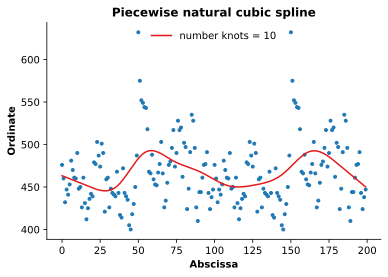

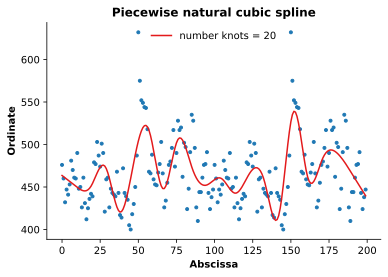

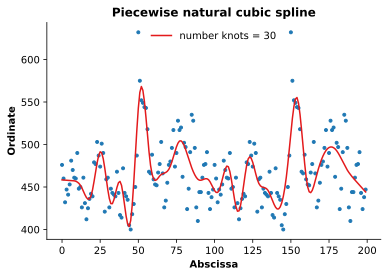

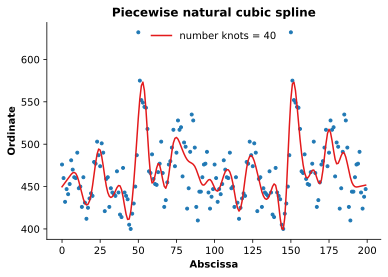

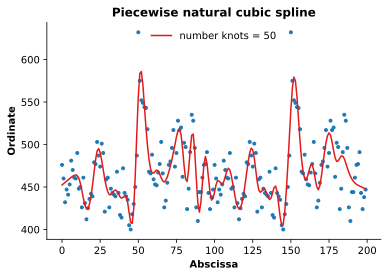

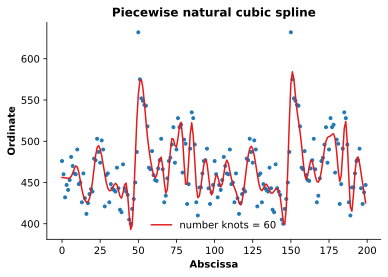

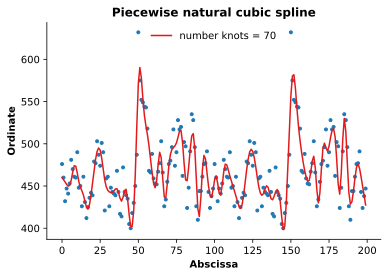

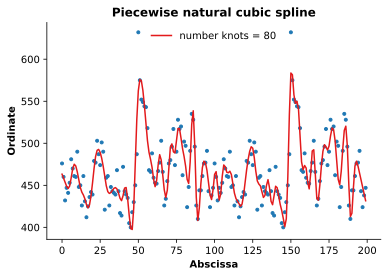

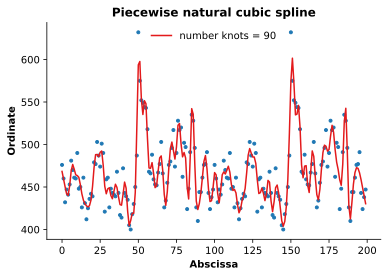

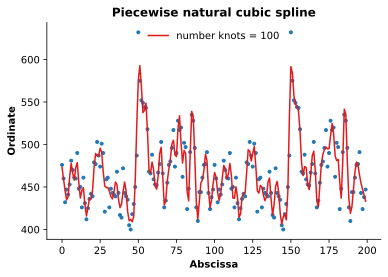

In [7]:
if __name__ == '__main__':
    main()